In [47]:
import time
import datetime

In [52]:
datetime.time()

datetime.time(0, 0)

In [46]:
time.localtime()

time.struct_time(tm_year=2023, tm_mon=1, tm_mday=30, tm_hour=14, tm_min=44, tm_sec=53, tm_wday=0, tm_yday=30, tm_isdst=0)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook
import matplotlib as mpl

import scipy.signal as signal
import scipy.ndimage as ndimage
import numba
from numba import njit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML

import skimage.transform as sktransform 
from skimage import color, morphology

plt.rcParams["animation.html"] = "jshtml"

import pickle
import torch

In [4]:
def distance_kernel(half_extent=50):
    size = half_extent * 2 + 1
    kernel = np.zeros((size, size))
    vals = np.arange(-half_extent,half_extent+1)
    xx, yy = np.meshgrid(vals, vals, indexing='xy')
    # y, x = np.ogrid[-half_extent:half_extent+1, -half_extent:half_extent+1]
    distance = np.sqrt(xx**2 + yy**2)
    return distance
    
def tophat(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel[dists < radius] = 1
    kernel = kernel / kernel.sum()
    return kernel

def gaussian(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel = np.exp(- dists**2. / (2 * scale**2.))
    kernel = kernel / kernel.sum()
    return kernel

def triangle(dists, scale=50):
    """triangle kernel, scale is when it hits zero"""
    kernel = np.zeros(dists.shape)
    kernel = scale - dists
    kernel[kernel < 0] = 0
    kernel = kernel / kernel.sum()
    return kernel

kernels = {
    "gauss": gaussian,
    "tophat": tophat,
    "triangle": triangle,
}

def make_noise_map(scale, shape, which="gauss"):
    num = shape[0] * shape[1]
    noise = np.random.uniform(size=num).reshape(shape)
    dists = distance_kernel(half_extent=scale*3)
    
    
    kern = kernels[which](dists, scale=scale)
    tmp = np.fft.irfft2(np.fft.rfft2(noise) * np.fft.rfft2(kern, noise.shape))
    tmp = tmp - tmp.min()
    tmp = tmp / tmp.max()
    
    return tmp

def convolve_map(canvas, scale, which = "gauss",):
    pad_width = scale*3
    padded = np.pad(canvas, pad_width = scale*3)
    half_extent = scale*2
    dists = distance_kernel(half_extent = half_extent)    
    kern = kernels[which](dists, scale = scale)
    
    # There's some shape difference here, which needs to be manually corrected with the padding
    # just offset the convolved image by the half_extent of the kernel...
    tmp = np.fft.irfft2(np.fft.rfft2(padded) * np.fft.rfft2(kern, padded.shape))
    tmp = tmp[pad_width+half_extent:-pad_width+half_extent, pad_width+half_extent:-pad_width+half_extent]
    return tmp

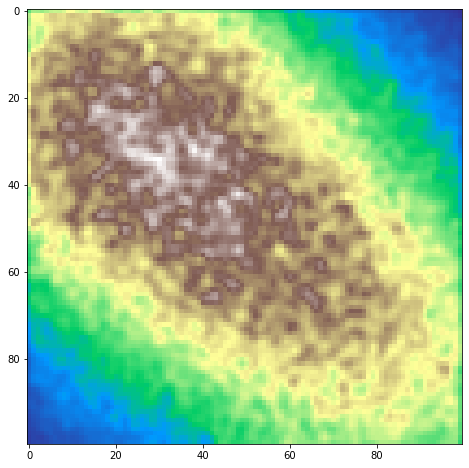

In [5]:
samples1 = np.random.multivariate_normal((1.7, 1.8), cov=np.eye(2), size=int(2.e6))
samples2 = np.random.multivariate_normal((0.4, 0.3), cov=np.eye(2), size=int(2.4e6))
# samples2 = np.random.multivariate_normal((3., 4.), cov=np.eye(2)*1, size=1800000)
# samples3 = np.random.multivariate_normal((4.5, 1.8), cov=np.eye(2), size=1100000)
# samples4 = np.random.multivariate_normal((7, 3), cov=np.eye(2)*1.5, size=2000000)
samples = np.concatenate((samples1, samples2))

bins = np.linspace(0, 2, 104)

bcens = bins[:-1] + np.diff(bins) / 2
land = np.histogram2d(samples[:, 0], samples[:, 1], bins=(bins, bins), density=True)[0] * 4
land = convolve_map(land, 1, which="gauss")
land = land[1:-2, 1:-1]

lmax = land.max()
land = (land / lmax)**3. * lmax
land *= 3000

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.imshow(land, cmap=plt.cm.terrain)

In [34]:
zland = ndimage.zoom(land, 4)

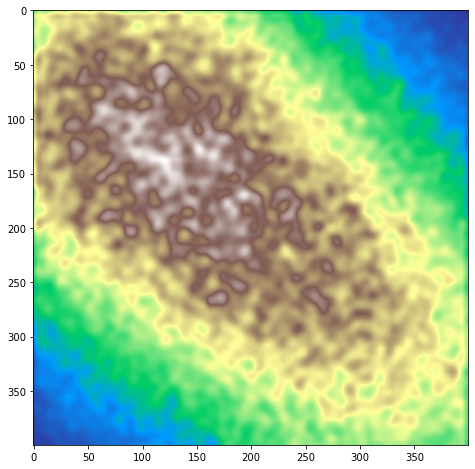

In [35]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.imshow(zland, cmap=plt.cm.terrain)

In [36]:
tzland = torch.from_numpy(zland)

In [37]:
def calc_shifted(inmap):
    """shift up, down, left, right"""

    omap = []
    tmp = np.roll(inmap, -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    tmp = np.roll(inmap, 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     
    return np.array(omap)   

def calc_unshifted(inmap):
    omap = []

    tmp = np.roll(inmap[0, :, :], 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[1, :, :], -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[2, :, :], 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     

    tmp = np.roll(inmap[3, :, :], -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    return np.array(omap)

# @jit
def center_cut(arr):
    """This was tested to go fastest with numpy  """
    return arr[1:-1, 1:-1]

def null_edges(arr):
    """THis was tested to go from 1.2us to 557ns with numba"""
    arr[0, :] = 0.
    arr[:, 0] = 0.
    arr[:, -1] = 0.
    arr[-1, :] = 0.
    return arr

In [38]:
def tcalc_shifted(inmap):
    """shift up, down, left, right"""

    omap = []
    tmp = torch.roll(inmap, -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = torch.roll(inmap, 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = torch.roll(inmap, -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    tmp = torch.roll(inmap, 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     
    return np.array(omap)   

def tcalc_unshifted(inmap):
    omap = []

    tmp = np.roll(inmap[0, :, :], 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[1, :, :], -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[2, :, :], 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     

    tmp = np.roll(inmap[3, :, :], -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    return np.array(omap)

# @jit
def tcenter_cut(arr):
    """This was tested to go fastest with numpy  """
    return arr[1:-1, 1:-1]

def tnull_edges(arr):
    """THis was tested to go from 1.2us to 557ns with numba"""
    arr[0, :] = 0.
    arr[:, 0] = 0.
    arr[:, -1] = 0.
    arr[-1, :] = 0.
    return arr

In [43]:
%timeit torch.from_numpy(zland)

577 ns ± 6.72 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [42]:
%timeit zland[0, 0]

55.1 ns ± 0.601 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [39]:
%timeit calc_shifted(zland)

494 µs ± 45.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [33]:
% timeit

tensor(1425.3396, dtype=torch.float64)

In [20]:
arr = calc_shifted(zland)

In [21]:
%timeit calc_unshifted(arr)

128 µs ± 3.97 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
